In [44]:
import numpy as np

In [45]:
from pyoculus.problems import SimsoptBfieldProblem

In [46]:
from simsopt.field import BiotSavart

In [94]:
from simsopt.field import load_coils_from_makegrid_file
coils = load_coils_from_makegrid_file('LHD_data/lhd.coils.txt', order=20)

In [40]:
import pandas as pd

data = [{"current": coil.current.get_dofs()[0]} for coil in coils]
df = pd.DataFrame(data)

In [43]:
df/df["current"][0]

,current
0,1.000000
1,1.000000
2,-0.523037
3,-0.523037
4,-0.126333
5,-0.126333
6,0.544444
7,0.544444


In [48]:
mf = BiotSavart(coils)
ps = SimsoptBfieldProblem.without_axis([3.9, 0], 5, mf, interpolate=False)

0 - dr : 0.01951057346748946
1 - RZ : [ 3.91877377e+00 -3.95987774e-04]
1 - dr : 0.001310010115274005
2 - RZ : [ 3.91762444e+00 -2.59758114e-06]
2 - dr : 4.9871404326163615e-06
3 - RZ : [3.91761994e+00 6.32231374e-09]
3 - dr : 7.188636823638532e-11


In [49]:
RZ0 = [ps._R0, ps._Z0]

In [ ]:
from simsopt.geo import CurvePlanarFourier
qpts_phi = np.linspace(0, 1, 50, endpoint=False)
dofs = np.concatenate(([ps._R0], np.zeros(7)))
curve = CurvePlanarFourier(qpts_phi, 0, 1, False)
curve.set_dofs(dofs)

In [92]:
rzs = np.array([[5.55, 1.55], [5.55, -1.55], [2.82, 2], [2.82, -2], [1.8, 0.8], [1.8, -0.8]])

from simsopt.geo import CurveRZFourier 
qpts_phi = np.linspace(0, 1, 50, endpoint=False)

for i in range(6):
    dofs = rzs[i,:]
    curve = CurveRZFourier(qpts_phi, 0, 0, False)
    curve.set_dofs(dofs)

    from mayavi import mlab
    coils[i+2].plot(engine='mayavi', show=False)
    curve.plot(engine='mayavi', show=False, color=(0, 0, 1))

    # print(coils[i+2].current.get_dofs()[0]/coils[0].current.get_dofs()[0])

    # mlab.show()

In [95]:
qpts_phi = np.linspace(0, 2*np.pi, 1000, endpoint=False)
Rs1 = 3.9*(1/3.9*np.cos(5*qpts_phi+0.1*np.sin(5*qpts_phi)) + 1)
Zs1 = 3.9*(-1/3.9*np.sin(5*qpts_phi+0.1*np.sin(5*qpts_phi)))

xs = Rs1*np.cos(qpts_phi)
ys = Rs1*np.sin(qpts_phi)
zs = Zs1

from mayavi import mlab
mlab.plot3d(xs, ys, zs, tube_radius=0.01, color=(0, 0, 1))
coils[0].plot(engine='mayavi', show=False)
mlab.show()

In [51]:
from simsopt.geo import SurfaceRZFourier
s = SurfaceRZFourier.from_nphi_ntheta(
    mpol=5,
    ntor=5,
    stellsym=True,
    nfp=5,
    range="full torus",
    nphi=64,
    ntheta=24,
)
s.fit_to_curve(curve, 1.5, flip_theta=False)

In [19]:
from mayavi import mlab
for coil in coils:
    coil.plot(engine='mayavi', show=False, close=True)
s.plot(engine='mayavi', opacity=0.4, show=False)

mlab.show()

In [52]:
pyoproblem = SimsoptBfieldProblem(ps._R0, ps._Z0, 5, mf, interpolate=True, surf=s, degree=4, n=40)

In [17]:
dist = pyoproblem.surfclassifier.evaluate_rphiz(np.array([[r, phi, z] for r, phi, z in zip(rrange, phirange, zrange)]))

In [53]:
n = 30
rs = np.linalg.norm(s.gamma()[:, :, 0:2], axis=2)
zs = s.gamma()[:, :, 2]
rrange = np.linspace(np.min(rs), np.max(rs), n)
phirange = np.linspace(0, 2 * np.pi / 5, n * 2)
zrange = np.linspace(0, np.max(zs), n // 2)

#rrange, phirange, zrange = np.meshgrid(rrange, phirange, zrange, indexing='ij')
rrange, zrange = np.meshgrid(rrange, zrange)

In [37]:
# for r, phi, z in zip(rrange, phirange, zrange):
#     x = r * np.cos(phi)
#     y = r * np.sin(phi)
#     mlab.points3d([x], [y], [z], scale_factor=0.1, color=(1, 0, 0))

for r, z in zip(rrange, zrange):
    x = r * np.cos(0)
    y = r * np.sin(0)
    mlab.points3d([x], [y], [z], scale_factor=0.1, color=(1, 0, 0))

for coil in coils:
    coil.plot(engine='mayavi', show=False, close=True)
# s.plot(engine='mayavi', show=False)

# Show the plot
mlab.show()

In [16]:
pyoproblem.surfclassifier.__dict__

{'zrange': (-1.6000000000000003, 1.6000000000000003),
 'rrange': (2.3176199420745967, 5.517619942074602),
 'dist': <simsoptpp.RegularGridInterpolant3D at 0x2023ed5f770>}

In [18]:
pyoproblem.B([3.9, 0., 0.])

array([-2.92316243e-13, -2.78172657e+00, -1.97556263e-01])

In [14]:
pyoproblem.dBdX([3.9, 0., 0.])

([array([-9.43689571e-16, -2.78171514e+00, -1.97554566e-01])],
 array([[ 7.77156117e-16,  3.34437429e-01, -1.43545525e+00],
        [ 3.34437441e-01, -2.31065167e-15,  8.56723775e-16],
        [-1.43545524e+00,  1.29170526e-15,  1.91513472e-15]]))

In [25]:
pyoproblem._mf_B.estimate_error_B(1000)

(0.3009218239153299, 0.3440880707298118)

In [21]:
pyoproblem.surfclassifier

In [14]:
import numpy as np

In [96]:
pyoproblem._Z0

6.322313735882947e-09

In [55]:
phis = [0]    #[(i / 4) * (2 * np.pi / nfp) for i in range(4)]

nfieldlines = 20
p1 = np.array([pyoproblem._R0, pyoproblem._Z0])
p2 = np.array([3.831, 0.75])
# p2 = np.array(results_x1[0][::2])
Rs = np.linspace(p1[0], p2[0], nfieldlines)
Zs = np.linspace(p1[1], p2[1], nfieldlines)

RZs = np.array([[r, z] for r, z in zip(Rs.flatten(), Zs.flatten())])

In [56]:
from horus import poincare

In [57]:
pplane = poincare(pyoproblem._mf_B, RZs, phis, pyoproblem.surfclassifier, tol = 1e-15, plot=False, tmax=100)

In [58]:
import matplotlib.pyplot as plt
%matplotlib ipympl
plt.style.use('lateky')

In [59]:
plt.ioff()
fig, ax = pplane.plot(phis)
ax = ax[0,0]

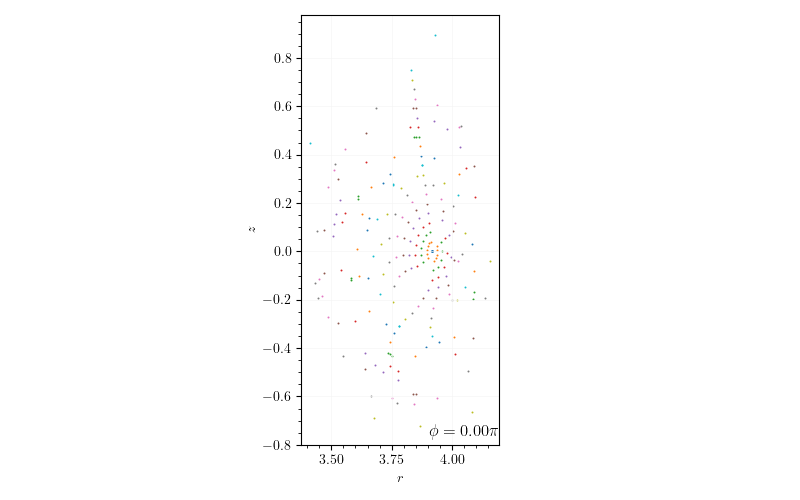

In [60]:
display(fig.canvas)

In [71]:
from pyoculus.problems import FixedPoint

# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-13

pparams = dict()
pparams["nrestart"] = 0
pparams["tol"] = 1e-15
pparams['niter'] = 100
# pparams["Z"] = 0 

fp_x1 = FixedPoint(pyoproblem, pparams, integrator_params=iparams)
fp_x1.compute(guess=[3.8962460336210425, 0.5584712678454549], pp=5, qq=15, sbegin=2, send=6, checkonly=True)

fp_x2 = FixedPoint(pyoproblem, pparams, integrator_params=iparams)
fp_x2.compute(guess=[3.896246033649848, -0.5584712678389868], pp=5, qq=15, sbegin=2, send=6, checkonly=True)

0 - [DeltaR, DeltaZ] : [-2.54019028e-13  2.22044605e-16] - dtheta : 18.849573672250436
0 - [DeltaR, DeltaZ] : [-9.81437154e-14  5.30686606e-14] - dtheta : 18.849537282843922


In [72]:
results_x1 = [list(p) for p in zip(fp_x1.x, fp_x1.y, fp_x1.z)]
results_x2 = [list(p) for p in zip(fp_x2.x, fp_x2.y, fp_x2.z)]

In [ ]:
ax.scatter(results_x1[0][0], results_x1[0][2], marker="X", edgecolors="black", linewidths=1)
ax.scatter(results_x2[0][0], results_x2[0][2], marker="X", edgecolors="black", linewidths=1)

In [73]:
results_x1[0]

[3.8962460336210425, 0.0, 0.5584712678454549]

In [1]:
from horus import trace
gamma = trace(ps._mf, 20*2*np.pi, results_x1[0], tol=1e-13)[0]

colors = [(1,0,0), (0,1,0), (0,0,1), (1,1,0), (0,1,1)]
for ii, phi in enumerate([0, 2*np.pi/5, 4*np.pi/5, 6*np.pi/5, 8*np.pi/5]):
    for r, z in zip(rrange, zrange):
        x = r * np.cos(phi)
        y = r * np.sin(phi)
        mlab.points3d([x], [y], [z], scale_factor=0.1, color=colors[ii])

for coil in coils:
    coil.plot(engine='mayavi', show=False, close=True)

mlab.plot3d(gamma[0, :], gamma[1, :], gamma[2, :], tube_radius=0.01, color=(0, 0, 1))
mlab.show()

NameError: name 'ps' is not defined

In [98]:
import pickle
tys, phi_hits = pickle.load(open("pplane.pkl", "rb"))

In [100]:
from horus import plot_poincare_data

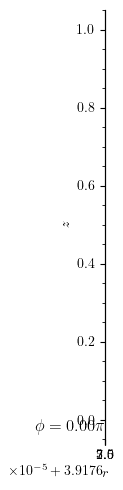

In [105]:
fig, ax = plot_poincare_data(phi_hits, [0])
display(fig)